In [32]:
from time import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import qmc

import statsmodels.api as sm

from pymoo.problems import get_problem

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.covariance import EllipticEnvelope, EmpiricalCovariance
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDOneClassSVM, LinearRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.models.abod import ABOD
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.ocsvm import OCSVM
from pyod.models.mcd import MCD
from pyod.models.pca import PCA
from pyod.models.loci import LOCI

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

In [43]:
class Benchmark:
    def __init__(self, name: str, dim: int = None):
        self.name = name.lower()
        self.dim = dim
        
        if self.name == "rosenbrock":
            if self.dim is None:
                raise ValueError("Set dim for Rosenbrock")
            self.problem = get_problem("rosenbrock", n_var=self.dim)
        elif self.name == "kursawe":
            self.problem = get_problem("kursawe")
            self.dim = self.problem.n_var
        elif self.name == "sphere":
            if self.dim is None:
                self.dim = 2
            self.problem = get_problem("sphere", n_var=self.dim)
        else:
            self.problem = get_problem(self.name, n_var=self.dim)
            if self.dim is None:
                self.dim = self.problem.n_var
        
        self.bounds = np.vstack([self.problem.xl, self.problem.xu]).T

    # DoE generators
    def sample_sobol(self, n_points: int, scramble: bool = True):
        sampler = qmc.Sobol(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_halton(self, n_points: int, scramble: bool = True):
        sampler = qmc.Halton(d=self.dim, scramble=scramble)
        sample = sampler.random(n_points)
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])
    
    def sample_lhs(self, n_points: int, criterion: str = "random-cd", seed: int = 42): # values of criterion : 'random-cd', 'lloyd'
        sampler = qmc.LatinHypercube(d=self.dim, optimization=criterion, seed=seed)
        sample = sampler.random(n_points)
        # print("LHS discrepancy:", qmc.discrepancy(sample))
        return qmc.scale(sample, self.bounds[:,0], self.bounds[:,1])

    def evaluate(self, X: np.ndarray):
        return self.problem.evaluate(X)
    
    def inject_outliers(self, X, Y, frac: float = 0.05, scale_factor: float = 0.2):
        """Inject near-outliers into Y (output). Returns noisy Y and indices of injected outliers."""
        n_outliers = max(1, int(frac * X.shape[0]))
        idx = np.random.choice(X.shape[0], n_outliers, replace=False)
        Y_out = Y.copy()
        scale = np.std(Y, axis=0) * scale_factor
        if Y_out.ndim == 1:
            Y_out[idx] = Y_out[idx] + np.random.normal(0, scale, size=n_outliers)
        else:
            Y_out[idx, 0] = Y_out[idx, 0] + np.random.normal(0, scale, size=n_outliers)
        return Y_out, idx


In [34]:
class StatisticalOutlierDetection:
    def z_score(self, data, threshold: float = 3.0):
        z_scores = np.abs(stats.zscore(data, axis=0))
        scores = np.max(z_scores, axis=1)
        return scores > threshold, scores

    def iqr(self, data, factor: float = 1.5):
        Q1 = np.percentile(data, 25, axis=0)
        Q3 = np.percentile(data, 75, axis=0)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        mask = np.any((data < lower) | (data > upper), axis=1)
        dist = np.max(np.maximum(0, data - upper) + np.maximum(0, lower - data), axis=1)
        return mask, dist

    def leverage(self, X, threshold: float = None):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        X_design = np.column_stack([np.ones(X.shape[0]), X])
        H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
        leverages = np.diag(H)
        if threshold is None:
            threshold = 2 * X_design.shape[1] / X_design.shape[0]
        return leverages > threshold, leverages

    def cooks_distance(self, X, y, threshold: float = None):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        y = y.ravel()
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        residuals = y - y_pred
        X_design = np.column_stack([np.ones(X.shape[0]), X])
        H = X_design @ np.linalg.pinv(X_design.T @ X_design) @ X_design.T
        leverages = np.diag(H)
        p = X_design.shape[1]
        n = X_design.shape[0]
        mse = np.sum(residuals**2) / max(1, (n - p))
        cooks_d = (residuals**2 / (p * mse)) * (leverages / (1 - leverages)**2)
        if threshold is None:
            threshold = 4 / n
        return cooks_d > threshold, cooks_d

    def mahalanobis(self, X, threshold: float = None):
        cov = EmpiricalCovariance().fit(X)
        m_dist = cov.mahalanobis(X)
        if threshold is None:
            # Use a high percentile as a generic cutoff; ROC will use the full score anyway
            threshold = np.percentile(m_dist, 97.5)
        return m_dist > threshold, m_dist

In [35]:
class MLOutlierDetection:

    def __init__(self):
        self.scaler = StandardScaler()

    def elliptic_envelope(self, X, contamination: float = 0.1):
        model = EllipticEnvelope(contamination=contamination, random_state=42)
        pred = model.fit_predict(self.scaler.fit_transform(X))
        return pred == -1, -model.decision_function(X)

    def isolation_forest(self, X, contamination: float = 0.1):
        model = IsolationForest(contamination=contamination, random_state=42)
        pred = model.fit_predict(self.scaler.fit_transform(X))
        return pred == -1, -model.decision_function(X)

    def lof(self, X, contamination: float = 0.1, n_neighbors: int = 20):
        model = LocalOutlierFactor(contamination=contamination, n_neighbors=n_neighbors)
        pred = model.fit_predict(self.scaler.fit_transform(X))
        return pred == -1, -model.negative_outlier_factor_

    def one_class_svm(self, X, nu: float = 0.1):
        model = OneClassSVM(gamma="scale", nu=nu)
        pred = model.fit_predict(self.scaler.fit_transform(X))
        return pred == -1, -model.decision_function(X)

    def sgd_one_class_svm(self, X, nu: float = 0.1):
        try:
            model = SGDOneClassSVM(nu=nu, random_state=42)
            pred = model.fit_predict(self.scaler.fit_transform(X))
            return pred == -1, -model.decision_function(X)
        except Exception:
            # If not available in the local sklearn version, return blanks
            return np.zeros(X.shape[0], dtype=bool), np.zeros(X.shape[0])
        
    def dbscan(self, X, eps: float = 0.5, min_samples: int = 5):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = model.fit_predict(self.scaler.fit_transform(X))
        outliers = labels == -1
        # Since DBSCAN doesn't provide anomaly scores, I set score=1 for outliers, 0 otherwise
        scores = outliers.astype(int)
        return outliers, scores

In [36]:
def evaluate_detection(true_idx, pred_mask, scores, method_name, duration, bench_name, dim):
    y_true = np.zeros(len(pred_mask), dtype=int)
    y_true[true_idx] = 1
    y_pred = pred_mask.astype(int)

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # Normalisation des scores pour AUC
    scores = np.asarray(scores)
    if np.max(scores) > np.min(scores):
        scores_norm = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
    else:
        scores_norm = scores
    try:
        auc = roc_auc_score(y_true, scores_norm)
    except:
        auc = np.nan

    return {
        "benchmark": bench_name,
        "dim": dim,
        "method": method_name,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": auc,
        "time": duration
    }

In [37]:
def run_detection(detector, X, Y, idx_outliers, bench_name, dim, label):
    t0 = time()
    mask, scores = detector(X, Y)
    duration = time() - t0
    return evaluate_detection(idx_outliers, mask, scores, label, duration, bench_name, dim)

In [38]:
def run_detection_pyod(model, X, Y, idx_outliers, bench_name, dim, label):
    from pyod.utils.utility import standardizer

    X_aug = np.hstack([X, Y.reshape(-1, 1)])
    X_norm, _ = standardizer(X_aug, X_aug)

    t0 = time()
    model.fit(X_norm)
    scores = model.decision_function(X_norm)
    preds = model.predict(X_norm)
    duration = time() - t0

    return evaluate_detection(idx_outliers, preds == 1, scores, label, duration, bench_name, dim)

In [60]:
from sklearn.base import clone

def run_benchmarks(benchmarks, dims, detectors_stat, detectors_ml, detectors_pyod, contamination = 0.05, N_list=500, scale_factors=[0.2, 10.0]):
   
    results_list = []

    for bench_name in benchmarks:
        for dim in dims:
            if bench_name == "kursawe" and dim != 3:
                    continue
            for N in N_list:
                # Instancier le benchmark
                bench = Benchmark(bench_name, dim=dim)
                X = bench.sample_lhs(N)
                Y = bench.evaluate(X)
                Y = np.asarray(Y).reshape(-1)

                for scale in scale_factors:
                    # Injection artificielle d’outliers avec scale factor
                    Y_noisy, idx = bench.inject_outliers(X, Y, frac=contamination, scale_factor=scale)

                    # Tester statistical detectors
                    for name, det in detectors_stat.items():
                        # res = run_detection(det, X, Y_noisy, idx, bench_name, dim, f"{name}_scale_{scale}")
                        res = run_detection(det, X, Y_noisy, idx, bench_name, dim, name)
                        res["N"] = N
                        res["scale_factor"] = scale
                        results_list.append(res)

                    # Tester ML detectors
                    for name, det in detectors_ml.items():
                        res = run_detection(det, X, Y_noisy, idx, bench_name, dim, name)
                        res["N"] = N
                        res["scale_factor"] = scale
                        results_list.append(res)

                    # Tester PyOD detectors
                    for name, model in detectors_pyod.items():
                        try:
                            model_instance = clone(model)
                            res = run_detection_pyod(model_instance, X, Y_noisy, idx, bench_name, dim, name)
                            res["N"] = N
                            res["scale_factor"] = scale
                            results_list.append(res)
                        except Exception as e:
                            print(f"Error with {name} on {bench_name} dim={dim} N={N} scale={scale}: {e}")
                            continue

    return pd.DataFrame(results_list)

## Running all benchmark with 5% of contamination

In [ ]:
# Définir tes détecteurs
contamination_rate = 0.05
N_list = [300, 500, 1000, 2000, 5000]
scale_factors = [0.2, 10.0]
random_state = np.random.RandomState(42)

detectors_stat = {
    "Z-Score": lambda X, Y: StatisticalOutlierDetection().z_score(Y.reshape(-1,1)),
    "IQR": lambda X, Y: StatisticalOutlierDetection().iqr(Y.reshape(-1,1)),
    "Leverage": lambda X, Y: StatisticalOutlierDetection().leverage(X),
    "Cook's D": lambda X, Y: StatisticalOutlierDetection().cooks_distance(X, Y),
    "Mahalanobis": lambda X, Y: StatisticalOutlierDetection().mahalanobis(np.hstack([X, Y.reshape(-1,1)])),
}

detectors_ml = {
    "IForest": lambda X, Y: MLOutlierDetection().isolation_forest(np.hstack([X, Y.reshape(-1,1)]), contamination=contamination_rate),
    "Robust Covariance": lambda X, Y: MLOutlierDetection().elliptic_envelope(np.hstack([X, Y.reshape(-1,1)]), contamination=contamination_rate),
    "LOF": lambda X, Y: MLOutlierDetection().lof(np.hstack([X, Y.reshape(-1,1)]), contamination=contamination_rate),
    "OCSVM": lambda X, Y: MLOutlierDetection().one_class_svm(np.hstack([X, Y.reshape(-1,1)]), nu=contamination_rate),
    #"SGD OCSVM": lambda X, Y: MLOutlierDetection().sgd_one_class_svm(np.hstack([X, Y.reshape(-1,1)]), nu=contamination_rate),
    #"DBSCAN": lambda X, Y: MLOutlierDetection().dbscan(np.hstack([X, Y.reshape(-1,1)]), eps=0.5, min_samples=5),
}

detectors_pyod = {
    "ABOD": ABOD(contamination=contamination_rate),
    "Feature Bagging": FeatureBagging(contamination=contamination_rate, random_state=random_state),
    "HBOS": HBOS(contamination=contamination_rate),
    "IForest": IForest(contamination=contamination_rate, random_state=random_state),
    "KNN": KNN(contamination=contamination_rate),
    "LOF": LOF(contamination=contamination_rate),
    "Robust Covariance": MCD(contamination=contamination_rate, random_state=random_state),
    "OCSVM": OCSVM(contamination=contamination_rate),
    "PCA": PCA(contamination=contamination_rate, random_state=random_state),
    "CBLOF": CBLOF(n_clusters=16, contamination=contamination_rate, check_estimator=False, random_state=random_state),
    "COPOD": COPOD(),
    
}

# Lancer plusieurs benchmarks et dimensions
df_results_0 = run_benchmarks(
    benchmarks=["rosenbrock", "sphere", "kursawe", "schwefel", "ackley", "rastrigin", "griewank"],
    dims=[3, 8, 15, 25, 50],
    detectors_stat=detectors_stat,
    detectors_ml=detectors_ml,
    detectors_pyod=detectors_pyod,
    N_list=N_list,
    scale_factors=scale_factors
)

#print(df_results.head())

Error with CBLOF on rosenbrock dim=8 N=300 scale=0.2: Could not form valid cluster separation. Please change n_clusters or change clustering method
Error with CBLOF on rosenbrock dim=15 N=300 scale=0.2: Could not form valid cluster separation. Please change n_clusters or change clustering method
Error with CBLOF on rosenbrock dim=15 N=300 scale=10.0: Could not form valid cluster separation. Please change n_clusters or change clustering method
Error with CBLOF on rosenbrock dim=15 N=500 scale=0.2: Could not form valid cluster separation. Please change n_clusters or change clustering method
Error with CBLOF on rosenbrock dim=15 N=500 scale=10.0: Could not form valid cluster separation. Please change n_clusters or change clustering method
Error with CBLOF on rosenbrock dim=15 N=1000 scale=0.2: Could not form valid cluster separation. Please change n_clusters or change clustering method
Error with CBLOF on rosenbrock dim=15 N=2000 scale=0.2: Could not form valid cluster separation. Please 

In [ ]:
# df_pivot = df_results.pivot_table(index=["benchmark","dim"], columns="method", values="roc_auc")
# print(df_pivot.corr())

method                                             DBSCAN_scale0.2  \
method                                                               
DBSCAN_scale0.2                                                NaN   
DBSCAN_scale10.0                                               NaN   
Histogram-base Outlier Detection (HBOS)_scale0.2               NaN   
Histogram-base Outlier Detection (HBOS)_scale10.0              NaN   
IQR_scale0.2                                                   NaN   
IQR_scale10.0                                                  NaN   
Isolation Forest_scale0.2                                      NaN   
Isolation Forest_scale10.0                                     NaN   
KNN_scale0.2                                                   NaN   
KNN_scale10.0                                                  NaN   
LOF_scale0.2                                                   NaN   
LOF_scale10.0                                                  NaN   
Robust Covariance_sc

In [53]:
# Créer une table pivot avec méthodes en colonnes
df_pivot = df_results.pivot_table(index=["benchmark","dim"], columns="method", values=["roc_auc","time"])

# Corrélation entre les méthodes (ROC uniquement)
corr_roc = df_pivot["roc_auc"].corr()
print("Correlation matrix (ROC AUC):")
print(corr_roc)

# Corrélation entre les méthodes (Time uniquement)
corr_time = df_pivot["time"].corr()
print("Correlation matrix (Execution Time):")
print(corr_time)


Correlation matrix (ROC AUC):
method             Cook's D  HBOS  IForest  IQR  KNN  LOF  Leverage  \
method                                                                
Cook's D                1.0   1.0      1.0 -1.0  1.0  1.0       1.0   
HBOS                    1.0   1.0      1.0 -1.0  1.0  1.0       1.0   
IForest                 1.0   1.0      1.0 -1.0  1.0  1.0       1.0   
IQR                    -1.0  -1.0     -1.0  1.0 -1.0 -1.0      -1.0   
KNN                     1.0   1.0      1.0 -1.0  1.0  1.0       1.0   
LOF                     1.0   1.0      1.0 -1.0  1.0  1.0       1.0   
Leverage                1.0   1.0      1.0 -1.0  1.0  1.0       1.0   
Mahalanobis             1.0   1.0      1.0 -1.0  1.0  1.0       1.0   
OCSVM                   NaN   NaN      NaN  NaN  NaN  NaN       NaN   
Robust Covariance       1.0   1.0      1.0 -1.0  1.0  1.0       1.0   
Z-Score                 1.0   1.0      1.0 -1.0  1.0  1.0       1.0   

method             Mahalanobis  OCSVM  Robust 

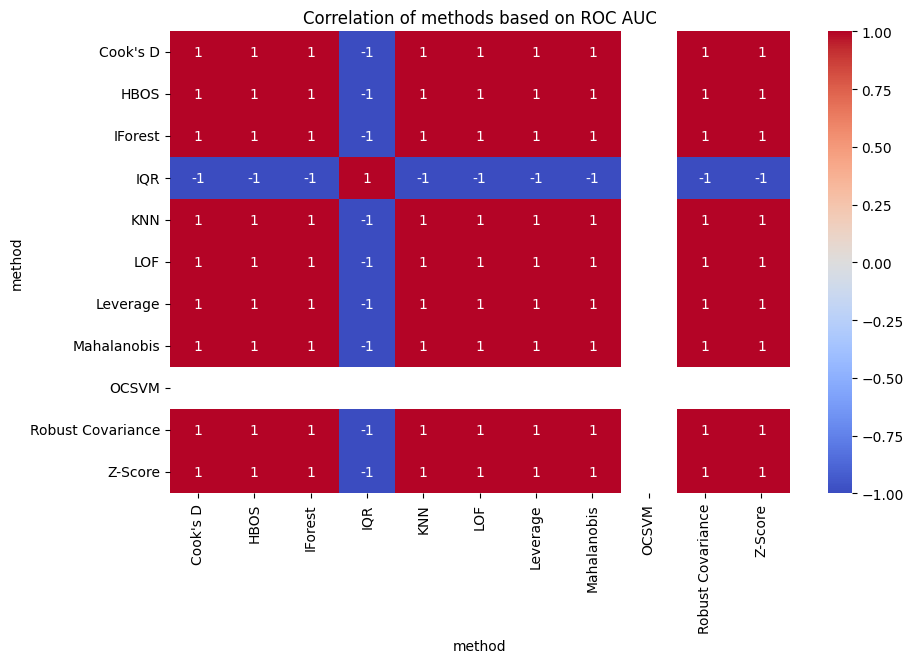

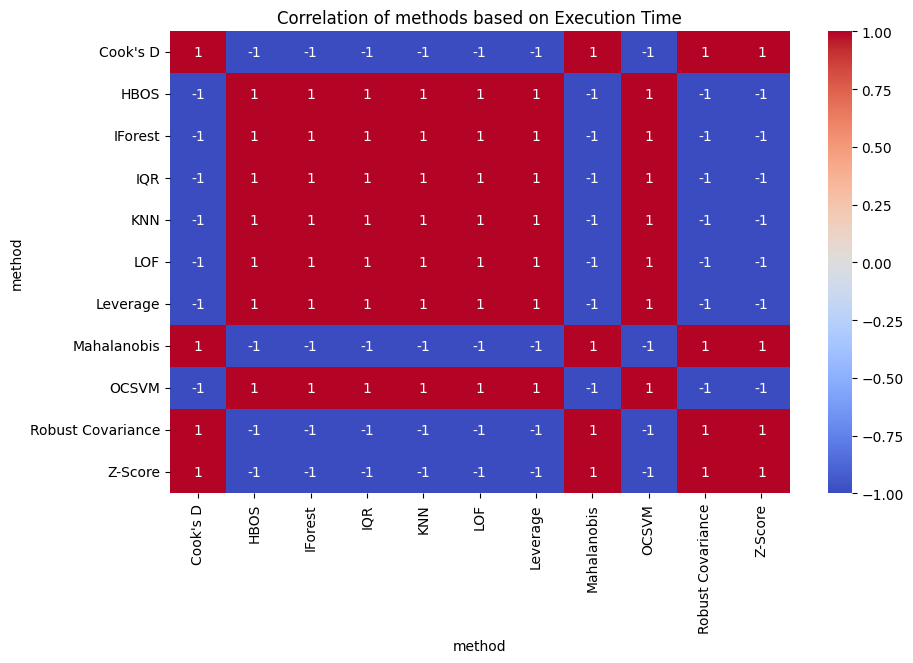

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(corr_roc, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of methods based on ROC AUC")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(corr_time, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation of methods based on Execution Time")
plt.show()